# Used Packages

In [565]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

import matplotlib.pyplot as plt
import matplotlib

# Model Creation

In [2]:
PATH = 'data'

##  Dataset

In [3]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [4]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [5]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

### Splitting Dataset

In [6]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [7]:
# setting the bert encoder and preprocessor
if not os.listdir('models'):
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
# generating the bert encoder and preprocess layer for the model
# (save model error can be fixed by deleting temp folder)
if not os.listdir('models'):
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
# function for building the classifiert model 
# text input -> preprocessing -> encode -> droput -> dense 
if not os.listdir('models'):
    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

In [10]:
# initialize classifier model
if not os.listdir('models'):
    classifier_model = build_classifier_model()

In [11]:
# sett loss and metric functions
if not os.listdir('models'):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

In [12]:
# set epochs and learning rate
if not os.listdir('models'):
    epochs = 5
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

In [13]:
if not os.listdir('models'):
    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

In [14]:
if not os.listdir('models'):
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

In [15]:
if not os.listdir('models'):
    loss, accuracy = classifier_model.evaluate(test_ds)

In [16]:
if not os.listdir('models'):
    dataset_name = 'imdb'
    saved_model_path = './models/{}_bert'.format(dataset_name.replace('/', '_'))

In [17]:
if not os.listdir('models'):
    classifier_model.save(saved_model_path, include_optimizer=False)

# Loading the model and working with it

In [285]:
if "saved_model_path" not in locals():
    saved_model_path = f'models/{os.listdir("models")[0]}'

In [19]:
model = tf.keras.models.load_model(saved_model_path, compile=False)

## Get complete test data

In [20]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

## Select random pair

In [519]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]

b"If you like the 80's rock, you should definitely see this movie! I've only seen it recently and completely fell in love with it!<br /><br />Overall, the movie is very entertaining, provides you with a great load of rock tunes and not a single second of the movie do I find boring! It was a great idea that some of the real-life musicians were in this, doing what they do best. I was happy to see Zakk, as well as Blas Elias, they all delivered solid performances. I tend to agree with a lot of people saying that the first half of the movie was much better than the second one, specially in the terms of the script.That could have been worked on a bit better, but not a major biggie. One thing that did bother me a bit was Jennifer Aniston's performance. I thought she wasn't the right person for this role,I just couldn't see her as a rock star girlfriend.But as the movie goes on, you somehow realize that she did a good job with this.There is a certain amount of honesty and sincerity she delive

In [520]:
#function to classify a text given a model

def classify_text(model, text, parent_ind=None, child_ind=None):
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    if parent_ind or child_ind:
        return (score, pred_label, parent_ind, child_ind)
    else:
        return (score, pred_label)

## Predict random pair

In [521]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nPrediction Strength: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 1 
Prediction Strength: 0.9990818500518799 
Real Label: 1


## Dependecy Parser

In [522]:
depend_parser = spacy.load('en_core_web_sm')

In [523]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [524]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

## Leave-n-out, strength calculation and linearization

In [626]:
# leave n out 
# go over all tokens, if a token has children, then for every token children pair
# return a text with both removed
new_texts = []
for token in parsed_text:
    if token.children:
        for child in token.children:
            new_text = []

            for item in parsed_text:
                if item.i == token.i or item.i == child.i:
                    pass
                else:
                    new_text.append(item.text)

            new_texts.append((" ".join(new_text), token.i, child.i))

In [627]:
# df of all created texts, with output strength, predicted label, parent index and child index
df = pd.DataFrame([
    classify_text(
        model, text_triple[0], text_triple[1], text_triple[2])
    for text_triple in new_texts],
    columns=['Output Strength',
             'Predicted Label',
             'Parent Index',
             'Child Index'])

df


,Output Strength,Predicted Label,Parent Index,Child Index
0,0.999247,1,0,2
1,0.999011,1,2,1
2,0.999038,1,2,6
3,0.999027,1,4,3
4,0.999031,1,4,5
...,...,...,...,...
257,0.999215,1,267,265
258,0.999215,1,267,266
259,0.999215,1,267,268
260,0.999215,1,267,270


In [628]:
# removes all texts which had the same output strength or better with the word pair removed
# thus not contributing to the prediction
df = df.drop(df.index[df['Output Strength'] >= org_text_pred[0]] )


In [629]:
# adds a new column Strength Difference which captures the difference of the new text prediction and the original
df['Strength Difference'] = org_text_pred[1] - df['Output Strength']


In [630]:
df_copy = df.copy()
df_copy[['Child Index', 'Parent Index']] = df[['Parent Index', 'Child Index']]
df = pd.concat([df, df_copy]).reset_index(drop=True)
df.drop(["Output Strength", "Predicted Label", "Child Index"], inplace=True, axis=1)
df = df.loc[df.groupby(['Parent Index'])["Strength Difference"].idxmax()]
df['Strength Difference'] = MinMaxScaler().fit_transform(df[['Strength Difference']])
df = df.sort_values(by=['Strength Difference'])
df.rename(columns={"Parent Index": "Token Index"}, inplace=True)
df

,Token Index,Strength Difference
76,67,0.000000
78,73,0.010441
55,14,0.015269
59,17,0.015752
56,12,0.016356
65,22,0.017080
20,23,0.017080
57,15,0.017563
54,13,0.020581
30,45,0.020701


In [631]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"])

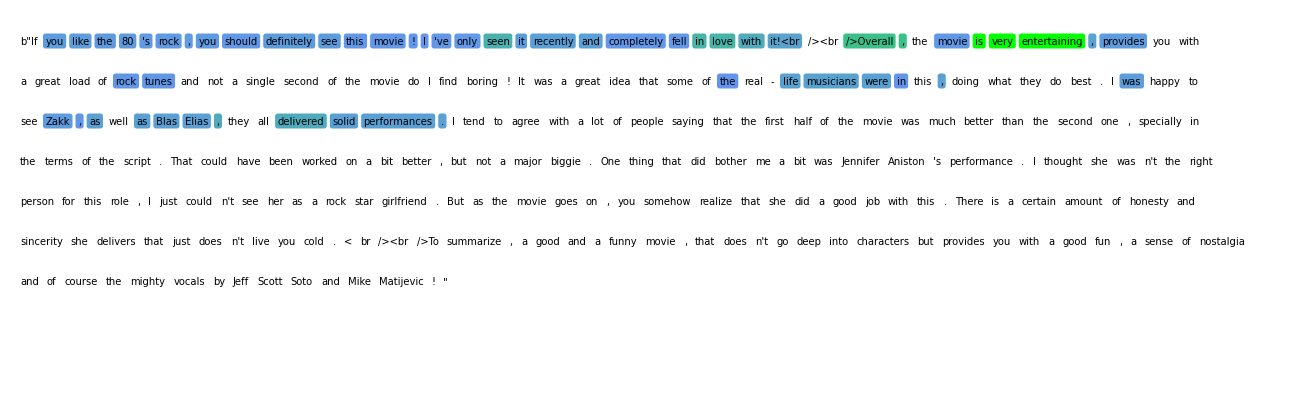

In [632]:
start_x = 20
start_y = 350
end = 1200
whitespace = 8

figure = plt.figure(figsize=(20, start_y/50))
rend = figure.canvas.get_renderer()

for token in parsed_text:
    if df.loc[df["Token Index"] == token.i, 'Strength Difference'].values.size > 0:
        col = cmap(df.loc[df["Token Index"] == token.i, 'Strength Difference'].values[0])
    else: 
        col = "white"
    bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

    # Check if word contains "foot", "feet", "foot." or "feet." or caps locked.
    # Depending what you are trying to achieve.
    txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)
    # Textbox width
    bb = txt.get_window_extent(renderer=rend)

    # Calculate where next word should be written
    start_x = bb.width + start_x + whitespace

    # Next line if end parameter in pixels have been crossed
    if start_x >= end:
        start_x = 20
        start_y -= 40

plt.axis("off")
plt.show()